In [1]:
# analysis of the cloud predictor increment in VarBC
# examine how the cloud predictor changes when using BC TB vs noBC TB (in a Hovmoller diagram)

# NOTE!!
# to plot the time averaged VarBC inc as a function of cloud amount
# refer to the notebook: compiled_radstat_omf_omfnbc_cloud_Hovemoller.ipynb

# initial built: 2024/12/19

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta


In [2]:
instrument = 'amsua'
channel    = 'ch1'
#exps       = ['full_only_clr','full_clr_cld','full_obs','full_model','full_sym']
#exps       = ['full_CTRL', 'full_only_clr','full_clr_cld','full_sym', 'full_sym_clwnbc']
exps = ['full_CTRL','full_only_clr']

init_time  = datetime(2022, 6, 10,  0, 0, 0)  # Year, month, day, hour, minute, second
final_time = datetime(2022, 8, 10,  0, 0, 0)  # Year, month, day, hour, minute, second
dt         = 12 # in hours

# Calculate the total time difference in hours
total_hours = (final_time - init_time).total_seconds() / 3600

# Calculate the number of timesteps
nt = int(total_hours / dt) +1

# define the cloud bins
x_cld = np.linspace(0,1,41)
nc    = len(x_cld) - 1 # number of cloud bins

# define the how to "bin" the clouds:
#cloud_predictor_name = ['Model Cloud']
cloud_predictor_name = ['Symmetric Cloud','Model Cloud', 'Obs Cloud']

In [3]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

dic_ndata = {};
dic_mean  = {};

datetime_ticks  = [];

for e, exp in enumerate(exps):
    
    print(f'now processing {exp}...')

    dic_ndata[exp]={}; 
    dic_mean[exp]={};
    
    current_time = init_time
    
    ndata_sym = np.zeros((nt,nc));
    mean_sym  = np.zeros((nt,nc));
    
    ndata_obs = np.zeros((nt,nc));
    mean_obs  = np.zeros((nt,nc));
    
    ndata_model = np.zeros((nt,nc));
    mean_model  = np.zeros((nt,nc));
    
    tt=0;
    
    while current_time <= final_time:

        cdate  = current_time.strftime("%Y%m%d%H")
        
        if e==0:
            datetime_ticks.append(cdate)
            
        if np.mod(tt,20) ==0:
            print(f'     time = {cdate}')

        root_path = '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/compile_radstats/csv_files/'
        fn = f'/{exp}/each_cycle/{cdate}/omf_stats_{instrument}_{channel}_{cdate}.csv'
        tmpdf=pd.read_csv(f'{root_path}/{fn}')

        # dfs = data frame screend
        #screen = ( tmpdf['errinv_ges'] >0 )
        screen = (tmpdf['fwater'] > 0.99) & (tmpdf['fland'] < 0.01) & ( tmpdf['errinv_ges'] >0 )
        #screen = (tmpdf['fwater'] > 0.99) & (tmpdf['fland'] < 0.01) & ( tmpdf['errinv_ges'] >0 ) & ( tmpdf['varbc_idx_ges']==1 )
        dfs = tmpdf.loc[screen]
        dfs['clw_sym'] = 0.5*(dfs['clw_obs'] + dfs['clw_bg_nobc_ges'])


        for cld_pred in cloud_predictor_name:


            for i in range(nc):

                if cld_pred == 'Obs Cloud':
                    cld_screen = (dfs['clw_obs'] >= x_cld[i]) & (dfs['clw_obs'] < x_cld[i+1])
                    dfs_cld = dfs.loc[cld_screen]
                    tb_inc  = dfs_cld['omfnbc_ges'] - dfs_cld['omf_ges']
                    
                    ndata_obs[tt,i] = dfs_cld.shape[0]
                    mean_obs[tt,i]  = np.mean(tb_inc)
                    
                elif cld_pred == 'Model Cloud':
                    cld_screen = (dfs['clw_bg_nobc_ges'] >= x_cld[i]) & (dfs['clw_bg_nobc_ges'] < x_cld[i+1])
                    dfs_cld = dfs.loc[cld_screen]
                    tb_inc  = dfs_cld['omfnbc_ges'] - dfs_cld['omf_ges']
                    
                    ndata_model[tt,i] = dfs_cld.shape[0]
                    mean_model[tt,i]  = np.mean(tb_inc)
                    
                elif cld_pred == 'Symmetric Cloud':
                    cld_screen = (dfs['clw_sym'] >= x_cld[i]) & (dfs['clw_sym'] < x_cld[i+1])
                    dfs_cld = dfs.loc[cld_screen]
                    tb_inc  = dfs_cld['omfnbc_ges'] - dfs_cld['omf_ges']
                    
                    ndata_sym[tt,i] = dfs_cld.shape[0]
                    mean_sym[tt,i]  = np.mean(tb_inc)
       
        # progress to the next time step
        current_time = current_time + timedelta(hours=dt)
        tt+=1
    
    # put the matrix to the dictionary:
    dic_ndata[exp]['Obs Cloud']       = ndata_obs
    dic_ndata[exp]['Model Cloud']     = ndata_model
    dic_ndata[exp]['Symmetric Cloud'] = ndata_sym

    dic_mean[exp]['Obs Cloud']       = mean_obs
    dic_mean[exp]['Model Cloud']     = mean_model
    dic_mean[exp]['Symmetric Cloud'] = mean_sym


now processing full_CTRL...
     time = 2022061000
     time = 2022062000
     time = 2022063000
     time = 2022071000
     time = 2022072000
     time = 2022073000
     time = 2022080900
now processing full_only_clr...
     time = 2022061000
     time = 2022062000
     time = 2022063000
     time = 2022071000
     time = 2022072000
     time = 2022073000
     time = 2022080900


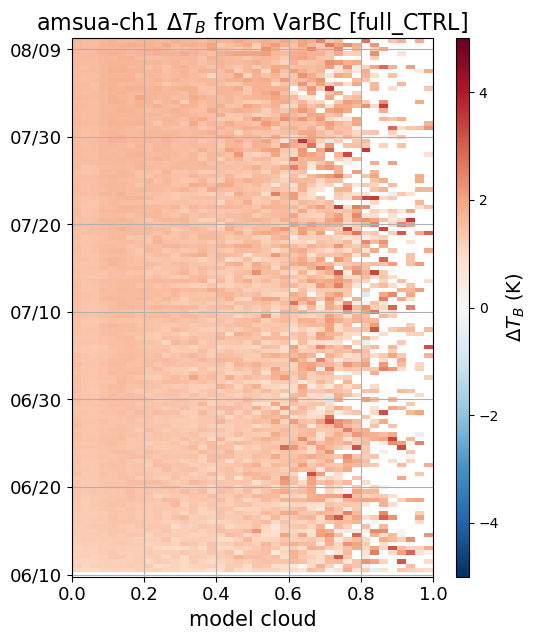

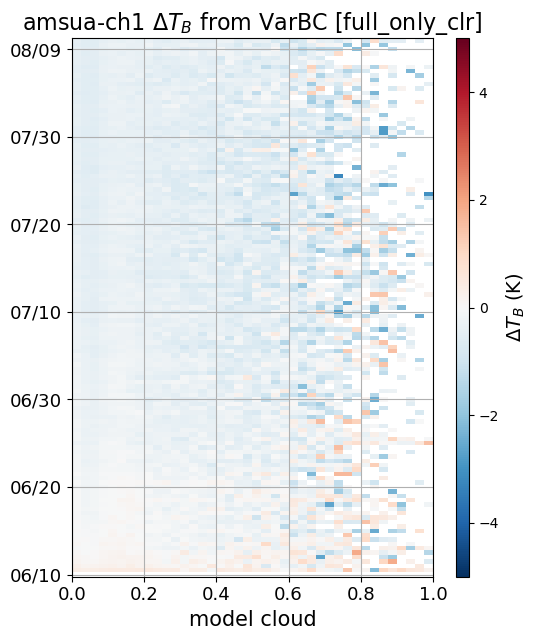

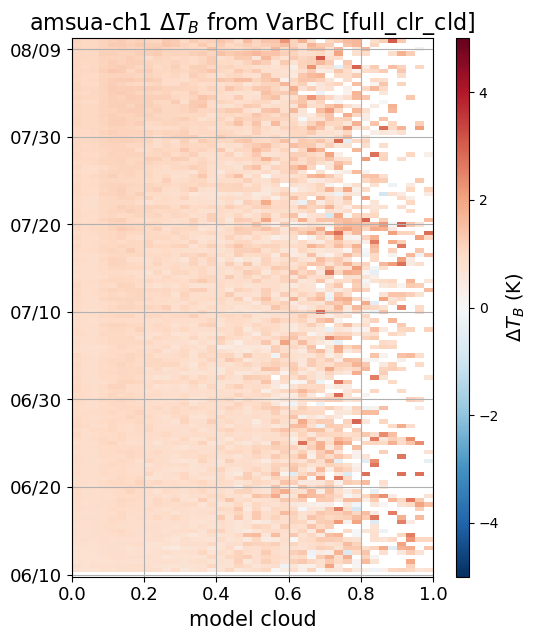

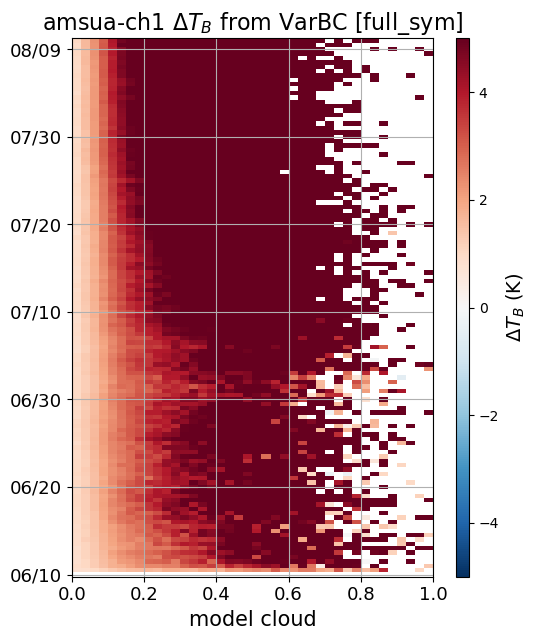

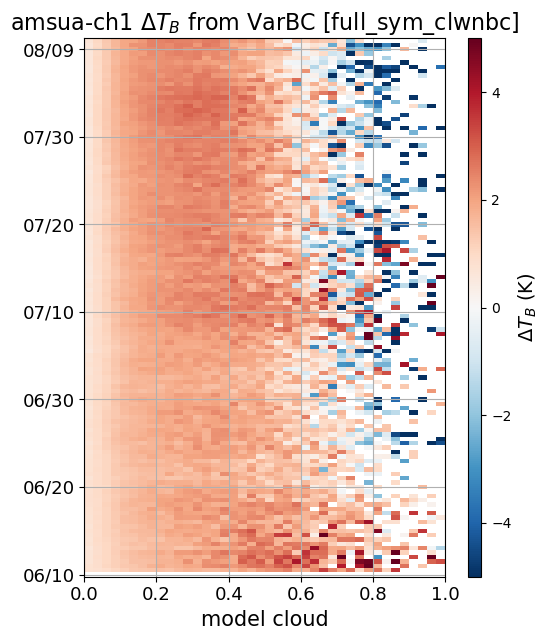

In [6]:
# Plot Section -- model cloud

save_figure = True

if channel in ('ch4'):
    vmin = -2
    vmax =  2
elif channel in ('ch5'):
    vmin = -1
    vmax =  1
else:
    vmin = -5
    vmax =  5

x_grid = 0.5*(x_cld[:-1] + x_cld[1:])
xs, ts = np.meshgrid(x_grid, np.arange(0,nt))

for exp in exps:
    
    fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/varBC_coeff_analysis/total_inc_Hovmoller_cloud/{exp}'

    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
        print(f"Directory '{fig_dir}' created.")

    fig, ax = plt.subplots(figsize=(5.5,6.5))
    contour = ax.pcolormesh(xs, ts, dic_mean[exp]['Model Cloud'], cmap='RdBu_r', vmin=vmin, vmax=vmax)

    interval = 20
    ticks_to_show = np.arange(0,nt)[::interval]
    ax.set_yticks(ticks_to_show)

    ticks_to_show = datetime_ticks[::interval]
    ticks_labels = [f'{dt[4:6]}/{dt[6:8]}' for dt in ticks_to_show]
    ax.set_yticklabels(ticks_labels, rotation=0,fontsize=13)
    ax.tick_params(axis='both', labelsize=13)
    ax.set_xlabel('model cloud', fontsize=15)

    ax.grid(True)
    ax.set_title(rf'{instrument}-{channel} $\Delta T_B$ from VarBC [{exp}]',fontsize=16)

    cbar = fig.colorbar(contour,location='right',aspect=40)
    cbar.set_label(r'$\Delta T_B$ (K)',fontsize=14)

    plt.tight_layout()
    if save_figure:
        plt.savefig(f"{fig_dir}/VarBC_TBinc_Hovmoller_model_cloud_sea_{instrument}_{channel}_{exp}.png")


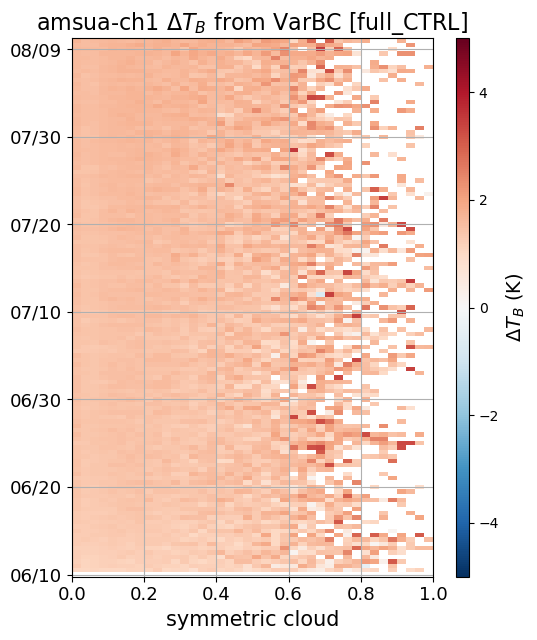

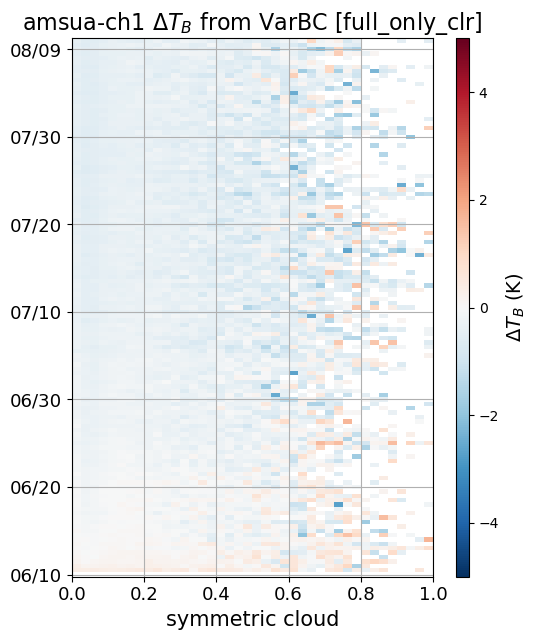

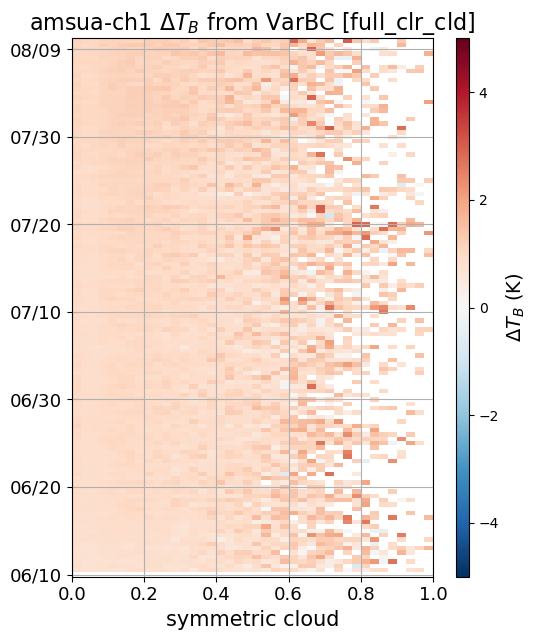

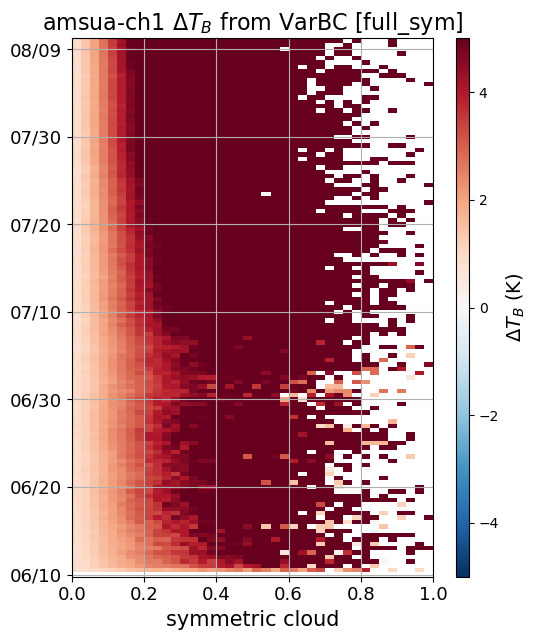

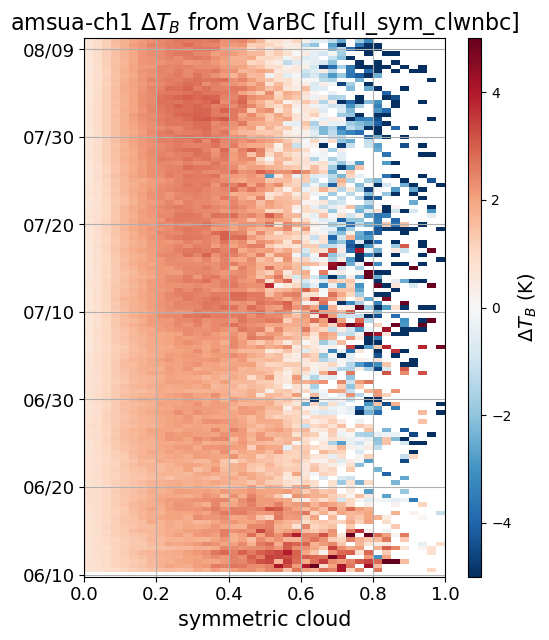

In [8]:
# Plot Section -- symmetric cloud

save_figure = True

vmin = -5
vmax =  5

x_grid = 0.5*(x_cld[:-1] + x_cld[1:])
xs, ts = np.meshgrid(x_grid, np.arange(0,nt))

for exp in exps:
    
    fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/varBC_coeff_analysis/total_inc_Hovmoller_cloud/{exp}'

    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
        print(f"Directory '{fig_dir}' created.")

    fig, ax = plt.subplots(figsize=(5.5,6.5))
    contour = ax.pcolormesh(xs, ts, dic_mean[exp]['Symmetric Cloud'], cmap='RdBu_r', vmin=vmin, vmax=vmax)

    interval = 20
    ticks_to_show = np.arange(0,nt)[::interval]
    ax.set_yticks(ticks_to_show)

    ticks_to_show = datetime_ticks[::interval]
    ticks_labels = [f'{dt[4:6]}/{dt[6:8]}' for dt in ticks_to_show]
    ax.set_yticklabels(ticks_labels, rotation=0,fontsize=13)
    ax.tick_params(axis='both', labelsize=13)
    ax.set_xlabel('symmetric cloud', fontsize=15)

    ax.grid(True)
    ax.set_title(rf'{instrument}-{channel} $\Delta T_B$ from VarBC [{exp}]',fontsize=16)

    cbar = fig.colorbar(contour,location='right',aspect=40)
    cbar.set_label(r'$\Delta T_B$ (K)',fontsize=14)

    plt.tight_layout()
    if save_figure:
        plt.savefig(f"{fig_dir}/VarBC_TBinc_Hovmoller_sym_cloud_sea_{instrument}_{channel}_{exp}.png")


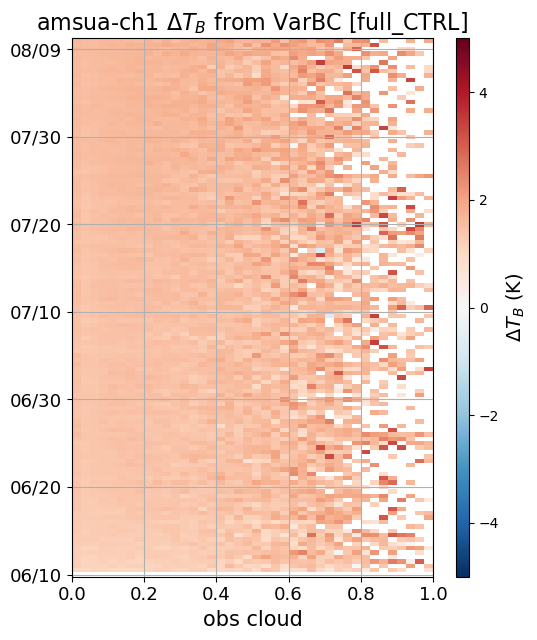

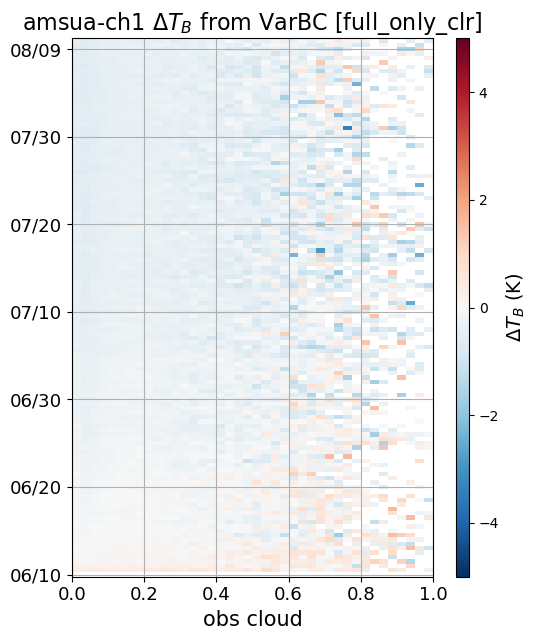

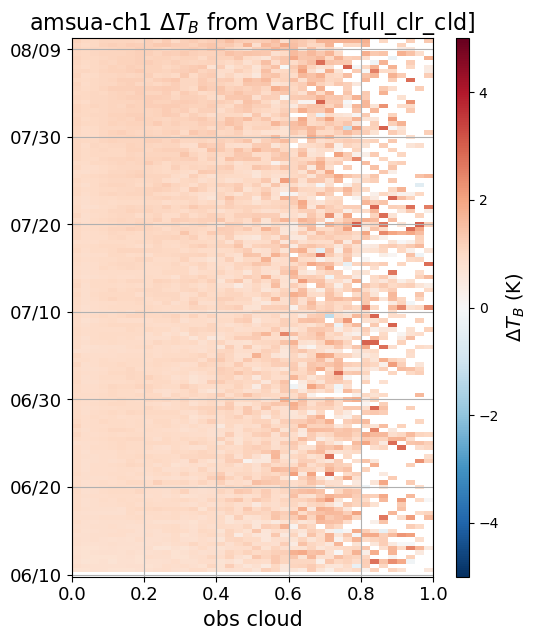

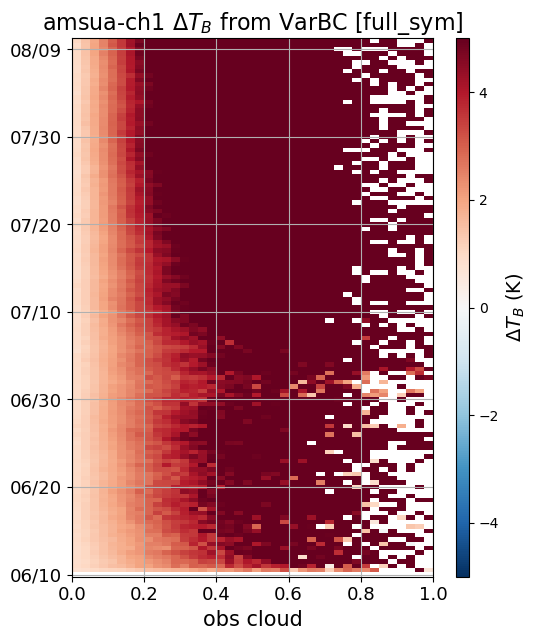

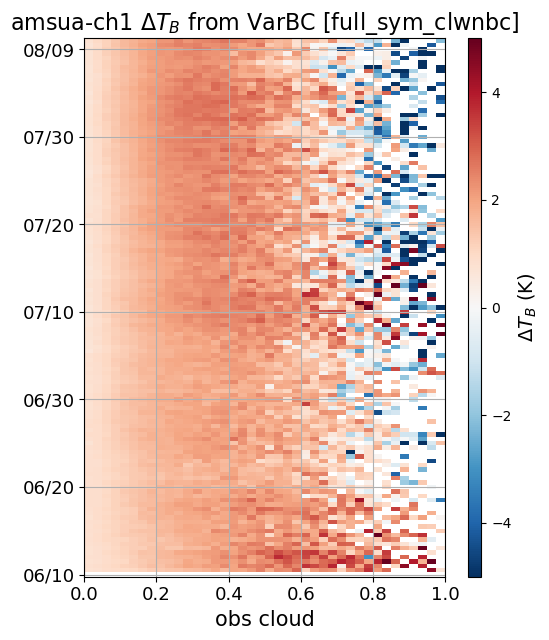

In [9]:
# Plot Section -- observation cloud

save_figure = True

vmin = -5
vmax =  5

x_grid = 0.5*(x_cld[:-1] + x_cld[1:])
xs, ts = np.meshgrid(x_grid, np.arange(0,nt))

for exp in exps:
    
    fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/varBC_coeff_analysis/total_inc_Hovmoller_cloud/{exp}'

    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
        print(f"Directory '{fig_dir}' created.")

    fig, ax = plt.subplots(figsize=(5.5,6.5))
    contour = ax.pcolormesh(xs, ts, dic_mean[exp]['Obs Cloud'], cmap='RdBu_r', vmin=vmin, vmax=vmax)

    interval = 20
    ticks_to_show = np.arange(0,nt)[::interval]
    ax.set_yticks(ticks_to_show)

    ticks_to_show = datetime_ticks[::interval]
    ticks_labels = [f'{dt[4:6]}/{dt[6:8]}' for dt in ticks_to_show]
    ax.set_yticklabels(ticks_labels, rotation=0,fontsize=13)
    ax.tick_params(axis='both', labelsize=13)
    ax.set_xlabel('obs cloud', fontsize=15)

    ax.grid(True)
    ax.set_title(rf'{instrument}-{channel} $\Delta T_B$ from VarBC [{exp}]',fontsize=16)

    cbar = fig.colorbar(contour,location='right',aspect=40)
    cbar.set_label(r'$\Delta T_B$ (K)',fontsize=14)

    plt.tight_layout()
    if save_figure:
        plt.savefig(f"{fig_dir}/VarBC_TBinc_Hovmoller_obs_cloud_sea_{instrument}_{channel}_{exp}.png")


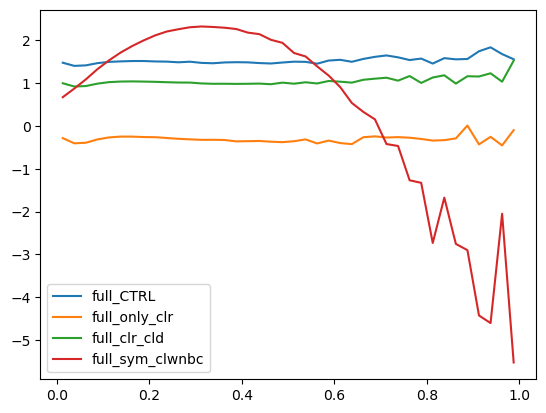

In [24]:
# time average of Hovemoller:
x_grid = 0.5*(x_cld[:-1] + x_cld[1:])

for exp in exps:
    if exp != 'full_sym':
        #plt.plot(x_grid, np.nanmean(dic_mean[exp]['Model Cloud'], axis=0), label=f'{exp}')
        #plt.plot(x_grid, np.nanmean(dic_mean[exp]['Obs Cloud'], axis=0), label=f'{exp}')
        plt.plot(x_grid, np.nanmean(dic_mean[exp]['Symmetric Cloud'], axis=0), label=f'{exp}')

    
plt.legend()

In [ ]:
plt.pcolormesh(dic_mean['full_clr_cld']['Obs Cloud'], )

In [ ]:
for cld_pred in cloud_predictor_name:

    for exp in exps:
        fig, ax1 = plt.subplots(figsize=(6,4.5))
        x_axis = 0.5*(x_cld[:-1] + x_cld[1:])
        ax1.plot(x_axis, dic_c25[exp][cld_pred],label='q25,q75',color='black',linestyle='--')
        ax1.plot(x_axis, dic_c50[exp][cld_pred],label='q50',color='black',linewidth=3)
        ax1.plot(x_axis, dic_c75[exp][cld_pred],color='black',linestyle='--')
        ax1.grid(True)
        ax1.set_xlim(0,1)
        ax1.set_ylim(-0.1,0.1)
        ax1.set_xlabel(rf'{cld_pred} ($kg/m^2$)', fontsize=13)
        ax1.set_ylabel(r'Model cloud increment ($kg/m^2$)', fontsize=13)
        #ax1.legend(loc='upper left')
        ax1.legend()
        ax1.tick_params(axis='both', labelsize=13)

        ax2 = ax1.twinx()
        ax2.bar(x_axis, dic_ndata[exp][cld_pred], width=0.05, color=(0.5, 0.5, 0.5), alpha=0.5)
        ax2.set_yscale('log')
        ax2.set_ylim(1,1e7)
        ax2.set_ylabel('data count', fontsize=13)
        ax2.tick_params(axis='both', labelsize=13)
        ax2.set_title(f'VarBC cloud increment ({sdate[4:6]}/{sdate[6:8]}-{edate[4:6]}/{edate[6:8]}) [{exp}]',fontsize=14)
        plt.show()

In [ ]:
for cld_pred in cloud_predictor_name:

    for exp in exps:
        fig, ax1 = plt.subplots(figsize=(6,4.5))
        x_axis = 0.5*(x_cld[:-1] + x_cld[1:])
        ax1.plot(x_axis, dic_t25[exp][cld_pred],label='q25,q75',color='black',linestyle='--')
        ax1.plot(x_axis, dic_t50[exp][cld_pred],label='q50',color='black',linewidth=3)
        ax1.plot(x_axis, dic_t75[exp][cld_pred],color='black',linestyle='--')
        ax1.grid(True)
        ax1.set_xlim(0,1)
        ax1.set_xlabel(rf'{cld_pred} ($kg/m^2$)', fontsize=13)
        ax1.set_ylabel(rf'$T_B$ ({instrument}-{channel}) increment (K)', fontsize=13)
        #ax1.legend(loc='upper left')
        ax1.legend()
        ax1.tick_params(axis='both', labelsize=13)

        ax2 = ax1.twinx()
        ax2.bar(x_axis, dic_ndata[exp][cld_pred], width=0.05, color=(0.5, 0.5, 0.5), alpha=0.5)
        ax2.set_yscale('log')
        ax2.set_ylim(1,1e7)
        ax2.set_ylabel('data count', fontsize=13)
        ax2.tick_params(axis='both', labelsize=13)
        ax2.set_title(rf'VarBC $T_B$ increment ({sdate[4:6]}/{sdate[6:8]}-{edate[4:6]}/{edate[6:8]}) [{exp}]',fontsize=14)

In [ ]:
cld_screen = (dfs['clw_obs'] >= 0.3)
dfs_cld = dfs.loc[cld_screen]
cloud_inc = dfs_cld['clw_bg_ges'] - dfs_cld['clw_bg_nobc_ges']

In [ ]:
cloud_inc.quantile(0.25)

In [ ]:
dfs_cld

In [ ]:
plt.hist(dfs_cld['omf_ges']-dfs_cld['omfnbc_ges'], bins=10, edgecolor='black')
plt.title('Histogram of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df={};
ct_clr_nobc={}; ct_clr_bc={}; ct_cld_nobc={}; ct_cld_bc={}; ct_mis_nobc={}; ct_mis_bc={};
ct_clr_clddiff={}; ct_cld_clddiff={};

for exp in exps:
    print(f'processing {exp}')
    current_time = init_time
    
    ct_clr_nobc[exp] = 0
    ct_clr_bc  [exp] = 0
    ct_cld_nobc[exp] = 0
    ct_cld_bc  [exp] = 0
    ct_mis_nobc[exp] = 0
    ct_mis_bc  [exp] = 0
    ct_clr_clddiff[exp] = 0
    ct_cld_clddiff[exp] = 0
    
    while current_time <= final_time:
        format_time  = current_time.strftime("%Y%m%d%H")
        
        if (current_time.hour == 0) & (np.mod(current_time.day,5)== 0):
            print(f'time = {format_time}')
        
        fn = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/compile_radstats/csv_files/{exp}/each_cycle/{format_time}/omf_stats_{instrument}_{channel}_{format_time}.csv'
        tmpdf=pd.read_csv(fn)
        
        # dfs = data frame screend
        screen = (tmpdf['fwater'] > 0.99) & (tmpdf['fland'] < 0.01) & ( tmpdf['errinv_ges'] >0 )
        dfs = tmpdf.loc[screen]

        # clr/clr and cld/cld definition
        cld_cri = 0.03
        clr_def = (dfs['clw_obs'] <= cld_cri) & (dfs['clw_bg_ges'] <= cld_cri)
        cld_def = (dfs['clw_obs']  > cld_cri) & (dfs['clw_bg_ges']  > cld_cri)
        mis_def = (dfs['clw_obs'] <= cld_cri) & (dfs['clw_bg_ges']  > cld_cri) | \
                  (dfs['clw_obs']  > cld_cri) & (dfs['clw_bg_ges'] <= cld_cri)

        df_clr = dfs.loc[clr_def]
        df_cld = dfs.loc[cld_def]
        df_mis = dfs.loc[mis_def]
        
        if norm_by == 'final_error':
            # normalized by the final obs error:
            omf_clr_nobc = plt_sign*df_clr['omfnbc_ges'].values * df_clr['errinv_ges'].values
            omf_clr_bc   = plt_sign*df_clr['omf_ges'].values    * df_clr['errinv_ges'].values
            omf_cld_nobc = plt_sign*df_cld['omfnbc_ges'].values * df_cld['errinv_ges'].values
            omf_cld_bc   = plt_sign*df_cld['omf_ges'].values    * df_cld['errinv_ges'].values
            omf_mis_nobc = plt_sign*df_mis['omfnbc_ges'].values * df_mis['errinv_ges'].values
            omf_mis_bc   = plt_sign*df_mis['omf_ges'].values    * df_mis['errinv_ges'].values
        
        elif norm_by == 'sym_error':
            ## normalized by the symmetric cloud
            omf_clr_nobc = plt_sign*df_clr['omfnbc_ges'].values / df_clr['symerr_ges'].values
            omf_clr_bc   = plt_sign*df_clr['omf_ges'].values    / df_clr['symerr_ges'].values
            omf_cld_nobc = plt_sign*df_cld['omfnbc_ges'].values / df_cld['symerr_ges'].values
            omf_cld_bc   = plt_sign*df_cld['omf_ges'].values    / df_cld['symerr_ges'].values
            omf_mis_nobc = plt_sign*df_mis['omfnbc_ges'].values / df_mis['symerr_ges'].values
            omf_mis_bc   = plt_sign*df_mis['omf_ges'].values    / df_mis['symerr_ges'].values        
        
        # define the bin_edges for the histogram
        dx = 0.05
        bin_max = 6
        
        bins = np.arange(-bin_max, bin_max+dx, dx)
        
        counts, _ = np.histogram(omf_clr_nobc, bins=bins)
        ct_clr_nobc[exp] += counts

        counts, _ = np.histogram(omf_clr_bc, bins=bins)
        ct_clr_bc  [exp] += counts
        
        counts, _ = np.histogram(omf_cld_nobc, bins=bins)
        ct_cld_nobc[exp] += counts
        
        counts, _ = np.histogram(omf_cld_bc, bins=bins)
        ct_cld_bc  [exp] += counts
        
        dx = 0.1
        bin_max = 6
        
        bins_mis = np.arange(-bin_max, bin_max+dx, dx)
        
        counts, _ = np.histogram(omf_mis_nobc, bins=bins_mis)
        ct_mis_nobc[exp] += counts
        
        counts, _ = np.histogram(omf_mis_bc, bins=bins_mis)
        ct_mis_bc  [exp] += counts
        
        ## calculate the cloud differnce:
        '''
        clr_clddiff = df_clr['clw_obs'] - df_clr['clw_bg_ges']
        cld_clddiff = df_cld['clw_obs'] - df_cld['clw_bg_ges']
        
        # define the bin_edges for the histogram
        dx = 0.005
        bin_max = 0.5
        
        bins = np.arange(-bin_max, bin_max+dx, dx)
        bin_center = 0.5*(bins[:-1] + bins[1:])
        
        counts, _ = np.histogram(clr_clddiff, bins=bins)
        ct_clr_clddiff[exp] += counts

        counts, _ = np.histogram(cld_clddiff, bins=bins)
        ct_cld_clddiff[exp] += counts     
        '''
        
        # progress to the next time step
        current_time = current_time + timedelta(hours=dt)

In [ ]:
# estimate the mean & mode of each pdfs:
mean_clr_bc={}; mean_clr_nobc={}; mean_cld_bc={}; mean_cld_nobc={}; mean_mis_nobc={}; mean_mis_bc={};
mode_clr_bc={}; mode_clr_nobc={}; mode_cld_bc={}; mode_cld_nobc={};

dx = 0.05
bin_max = 6

bins = np.arange(-bin_max, bin_max+dx, dx)
bin_center = 0.5*(bins[:-1] + bins[1:])

dx = 0.1
bin_max = 6

bins_mis = np.arange(-bin_max, bin_max+dx, dx)
bin_center_mis = 0.5*(bins_mis[:-1] + bins_mis[1:])

for exp in exps:
    mean_clr_bc[exp]   = sum(ct_clr_bc[exp]  *bin_center/sum(ct_clr_bc[exp]  ))
    mean_clr_nobc[exp] = sum(ct_clr_nobc[exp]*bin_center/sum(ct_clr_nobc[exp]))
    mean_cld_bc[exp]   = sum(ct_cld_bc[exp]  *bin_center/sum(ct_cld_bc[exp]  ))
    mean_cld_nobc[exp] = sum(ct_cld_nobc[exp]*bin_center/sum(ct_cld_nobc[exp]))
    mean_mis_bc[exp]   = sum(ct_mis_bc[exp]  *bin_center_mis/sum(ct_mis_bc[exp]  ))
    mean_mis_nobc[exp] = sum(ct_mis_nobc[exp]*bin_center_mis/sum(ct_mis_nobc[exp]))
    
    '''
    mode_clr_bc[exp]   = bin_center[np.where(ct_clr_bc[exp]   == max(ct_clr_bc[exp]))  ]
    mode_clr_nobc[exp] = bin_center[np.where(ct_clr_nobc[exp] == max(ct_clr_nobc[exp]))]
    mode_cld_bc[exp]   = bin_center[np.where(ct_cld_bc[exp]   == max(ct_cld_bc[exp]))  ]
    mode_cld_nobc[exp] = bin_center[np.where(ct_cld_nobc[exp] == max(ct_cld_nobc[exp]))]
    '''

In [ ]:
# Plot the clr/clr and cld/cld omf distribution

dx = 0.05
bin_max = 6

bins = np.arange(-bin_max, bin_max+dx, dx)
bin_center = 0.5*(bins[:-1] + bins[1:])

for exp in exps:
    #exptest = 'ctrl_noinf'
    fig, ax = plt.subplots(figsize=(6,5))
    ax.plot(bin_center, ct_clr_nobc[exp],linestyle='--' ,color='blue',  label=f'clr/clr nobc ({mean_clr_nobc[exp]:.2f})')
    ax.plot(bin_center, ct_clr_bc[exp],  linestyle='-'  ,color='blue',  label=f'clr/clr bc  ({mean_clr_bc[exp]:.2f})')
    ax.plot(bin_center, ct_cld_nobc[exp],linestyle='--' ,color='green', label=f'cld/cld nobc ({mean_cld_nobc[exp]:.2f})')
    ax.plot(bin_center, ct_cld_bc[exp],  linestyle='-'  ,color='green', label=f'cld/cld bc  ({mean_cld_bc[exp]:.2f})')
    ax.legend()
    if channel in ('ch4','ch5','ch6'):
        ax.set_xlim(-6,4)
    else:
        #ax.set_xlim(-4,4)
        ax.set_xlim(-2.5,2.5)
    
    if norm_by == 'final_error':
        if omf_or_fmo == 'omf':
            ax.set_xlabel('normalized OmF (by final error)',fontsize=14)
        else:
            ax.set_xlabel('normalized FmO (by final error)',fontsize=14)
    elif norm_by == 'sym_error':
        if omf_or_fmo == 'omf':
            ax.set_xlabel('normalized OmF (by symmetric cloud error)',fontsize=14)
        else:
            ax.set_xlabel('normalized FmO (by symmetric cloud error)',fontsize=14)

    ax.set_ylabel('Counts',fontsize=14)
    ax.set_ylim(-1000, 50000)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title(f'{instrument} {channel} ({exp})', fontsize=15)
    ax.grid(True)
    plt.savefig(f'clr_clr_cld_cld_{omf_or_fmo}_normby_{norm_by}_{instrument}_{channel}_{exp}.png', dpi=200, bbox_inches='tight')    

In [ ]:
# Plot cloud mismatch
# Plot the clr/clr and cld/cld omf distribution

dx = 0.1
bin_max = 6

bins_mis = np.arange(-bin_max, bin_max+dx, dx)
bin_center_mis = 0.5*(bins_mis[:-1] + bins_mis[1:])

for exp in exps:
    #exptest = 'ctrl_noinf'
    fig, ax = plt.subplots(figsize=(6,5))
    ax.plot(bin_center_mis, ct_mis_bc[exp],  linestyle='-'  ,color='black', label=f'mismatch bc  ({mean_mis_bc[exp]:.2f})')
    ax.plot(bin_center_mis, ct_mis_nobc[exp],linestyle='--' ,color='black', label=f'mismatch nobc ({mean_mis_nobc[exp]:.2f})')
    ax.legend(loc='upper right')
    if channel in ('ch4','ch5','ch6'):
        ax.set_xlim(-6,4)
    else:
        ax.set_xlim(-4,4)
    
    if norm_by == 'final_error':
        if omf_or_fmo == 'omf':
            ax.set_xlabel('normalized OmF (by final error)',fontsize=14)
        else:
            ax.set_xlabel('normalized FmO (by final error)',fontsize=14)
    elif norm_by == 'sym_error':
        if omf_or_fmo == 'omf':
            ax.set_xlabel('normalized OmF (by symmetric cloud error)',fontsize=14)
        else:
            ax.set_xlabel('normalized FmO (by symmetric cloud error)',fontsize=14)

    ax.set_ylabel('Counts',fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title(f'{instrument} {channel} ({exp})', fontsize=15)
    ax.grid(True)
    #plt.savefig(f'clr_clr_cld_cld_{omf_or_fmo}_normby_{norm_by}_{instrument}_{channel}_{exp}.png', dpi=200, bbox_inches='tight')    



In [ ]:
dfs[mis_def][['clw_obs', 'clw_bg_ges','omf_ges','omfnbc_ges']]

In [ ]:
plt.hist(dfs[mis_def]['omfnbc_ges'], bins=30, alpha=0.7, label='nobc')
plt.hist(dfs[mis_def]['omf_ges'], bins=30, alpha=0.7, label='bc')
plt.legend()